In [1]:
%pylab  inline
# TODO: batching errors? Have weird cell numbers
# TODO: create X for scRNAseq examples {small easy, medium (preselect HVGs), and full genome}
# TODO: plot scatter of latent vars (like UMAP??)
# TODO: output plot of top20 features per latent loading???
import scanpy as sc  # for interface to single cell stuff
import sys
sys.path.append('/home/ubuntu/spmf')
from mederrata_spmf import PoissonMatrixFactorization
import matplotlib.font_manager as fm
from matplotlib import rcParams
import matplotlib.pyplot as plt
import arviz as az
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import os
import csv
import seaborn as sns
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


rcParams['font.family'] = 'sans-serif'

sys.path.append('../')


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
# load the data
dataset_name = 'pbmc3k'
datapath = "/home/ubuntu/"
X = np.load(datapath + dataset_name + '_counts.npy')
gene_names = np.load(datapath + dataset_name +
                     '_genenames.npy', allow_pickle=True)
UMAP = np.load(datapath + dataset_name + '_UMAP.npy')

"""
mask = (X == 0).all(0)
# Find the indices of these columns
column_indices = np.where(mask)[0]
# Update x to only include the columns where non-zero values occur.
X = X[:, ~mask]
gene_names = gene_names[~mask]
"""

P = 4
D = X.shape[1]
N_BATCHES = 4
BATCH_SIZE = int(np.floor(X.shape[0]/N_BATCHES))

# normalization for cells, computed using all genes
counts_per_cell = X.sum(1)
after = np.median(np.array(counts_per_cell))
# after=1e4
size_factors = counts_per_cell / after
norm_vals = size_factors

# keep the first D genes
X = X[:, :D]
X_col_means = X.mean(axis=0, keepdims=True)

In [3]:
N, D = X.shape
# print(X.shape)
print(
    f"Total observations={X.shape[0]}, Batch size={BATCH_SIZE}: dropping {X.shape[0]%BATCH_SIZE} observations.")

# Test taking in from tf.dataset, don't pre-batch
dataset0 = tf.data.Dataset.from_tensor_slices(
    {
        'data': X,
        'indices': np.arange(N),
        'normalization': norm_vals
    })

# data = data.shuffle(buffer_size=N+1)
data = dataset0.batch(BATCH_SIZE, drop_remainder=True)


Total observations=2638, Batch size=659: dropping 2 observations.


In [4]:
# strategy = tf.distribute.MirroredStrategy()
# encoder_function=lambda x: tf.math.log(x+1), decoder_function=lambda x: tf.math.exp(x)-1,
# encoder_function=lambda x: x, decoder_function=lambda x: x,
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    scale_columns=True, with_s=True,
    encoder=lambda x: log(x/X_col_means+1), decoder= lambda x: exp(x*X_col_means)-1,
    u_tau_scale=1.0/np.sqrt(D*N), column_norms=X_col_means,
    dtype=tf.float64)

losses = factor.calibrate_advi(
    num_steps=500, learning_rate=0.05)

Feature dim: 13656 -> Latent dim 4
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initial loss: 6656.483617452119
Epoch 1: average-batch loss: 6533.414457033846 last batch loss: 6465.780243360605
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 6403.2077985047035 last batch loss: 6420.811942269993
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 6311.236221048728 last batch loss: 6286.95031355163
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 6267.271688362215 last batch loss: 6240.481988766751
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 6188.614149404027 last batch loss: 6207.939189742137
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 6107.119933481285 last batch loss: 6081.274043729016
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 6076.706959606531 last batch loss: 6049.268037782433
Saved a checkpoint: ./.tf_ckpts/chkpt-

Epoch 64: average-batch loss: 4065.337257154842 last batch loss: 4070.79695329278
Saved a checkpoint: ./.tf_ckpts/chkpt-64
Epoch 65: average-batch loss: 4042.195066388872 last batch loss: 4061.6715210303355
Saved a checkpoint: ./.tf_ckpts/chkpt-65
Epoch 66: average-batch loss: 4021.1270181250225 last batch loss: 4028.3379456688817
Saved a checkpoint: ./.tf_ckpts/chkpt-66
Epoch 67: average-batch loss: 4013.172919898809 last batch loss: 4020.7415229502362
Saved a checkpoint: ./.tf_ckpts/chkpt-67
Epoch 68: average-batch loss: 3993.9126942231924 last batch loss: 4013.924888651612
Saved a checkpoint: ./.tf_ckpts/chkpt-68
Epoch 69: average-batch loss: 3976.288013404359 last batch loss: 3985.8649273793644
Saved a checkpoint: ./.tf_ckpts/chkpt-69
Epoch 70: average-batch loss: 3969.466475268353 last batch loss: 3979.4738769738856
Saved a checkpoint: ./.tf_ckpts/chkpt-70
Epoch 71: average-batch loss: 3953.604665542813 last batch loss: 3972.9767085391413
Saved a checkpoint: ./.tf_ckpts/chkpt-71
E

Epoch 134: average-batch loss: 3749.295602716351 last batch loss: 3768.283085744889
We are in a loss plateau learning rate: 0.0010137779795222639 loss: 3776.97874332398
Restoring from a checkpoint - loss: 3776.862233549443
Epoch 135: average-batch loss: 3745.5563865276526 last batch loss: 3761.886483579693
Epoch 136: average-batch loss: 3744.750947286815 last batch loss: 3761.6885302056057
Batch loss NaN
Epoch 137: average-batch loss: 3738.4011082062643 last batch loss: 3768.1652674494107
Epoch 138: average-batch loss: 3748.2107372793826 last batch loss: 3767.0188065287794
Epoch 139: average-batch loss: 3747.729968665335 last batch loss: 3766.2423156460754
Batch loss NaN
Epoch 140: average-batch loss: 3737.550571200049 last batch loss: 3765.0525959286438
Saved a checkpoint: ./.tf_ckpts/chkpt-110
Epoch 141: average-batch loss: 3744.951487049071 last batch loss: 3763.4094036762117
Epoch 142: average-batch loss: 3745.1980202066616 last batch loss: 3766.289597629547
We are in a loss platea

Epoch 203: average-batch loss: 3637.6956594053945 last batch loss: 3654.3372696766573
Saved a checkpoint: ./.tf_ckpts/chkpt-157
Epoch 204: average-batch loss: 3635.839874396136 last batch loss: 3653.0461004738772
Saved a checkpoint: ./.tf_ckpts/chkpt-158
Epoch 205: average-batch loss: 3634.125584437842 last batch loss: 3651.3471304661157
Saved a checkpoint: ./.tf_ckpts/chkpt-159
Epoch 206: average-batch loss: 3632.383708842137 last batch loss: 3649.819292470523
Saved a checkpoint: ./.tf_ckpts/chkpt-160
Epoch 207: average-batch loss: 3630.6579483621563 last batch loss: 3647.3621652636893
Saved a checkpoint: ./.tf_ckpts/chkpt-161
Epoch 208: average-batch loss: 3628.9342879623096 last batch loss: 3645.9312229483844
Saved a checkpoint: ./.tf_ckpts/chkpt-162
Epoch 209: average-batch loss: 3626.911589149758 last batch loss: 3644.434802729478
Saved a checkpoint: ./.tf_ckpts/chkpt-163
Epoch 210: average-batch loss: 3625.35883651354 last batch loss: 3642.9294876284284
Saved a checkpoint: ./.tf_

Epoch 268: average-batch loss: 3560.483882849133 last batch loss: 3578.0372099418914
Saved a checkpoint: ./.tf_ckpts/chkpt-222
Epoch 269: average-batch loss: 3560.487125801806 last batch loss: 3578.6722166233517
Epoch 270: average-batch loss: 3559.2901878671814 last batch loss: 3576.8181508680486
Saved a checkpoint: ./.tf_ckpts/chkpt-223
Epoch 271: average-batch loss: 3559.219465842281 last batch loss: 3576.6226680312748
Saved a checkpoint: ./.tf_ckpts/chkpt-224
Epoch 272: average-batch loss: 3558.616241565192 last batch loss: 3575.7515166345074
Saved a checkpoint: ./.tf_ckpts/chkpt-225
Epoch 273: average-batch loss: 3557.80960208727 last batch loss: 3575.583478784363
Saved a checkpoint: ./.tf_ckpts/chkpt-226
Epoch 274: average-batch loss: 3557.604645678043 last batch loss: 3575.874813409995
Saved a checkpoint: ./.tf_ckpts/chkpt-227
Epoch 275: average-batch loss: 3557.0457170655973 last batch loss: 3574.2297169210897
Saved a checkpoint: ./.tf_ckpts/chkpt-228
Epoch 276: average-batch lo

Epoch 333: average-batch loss: 3537.933502117906 last batch loss: 3555.472299685316
Saved a checkpoint: ./.tf_ckpts/chkpt-279
Epoch 334: average-batch loss: 3538.014355763138 last batch loss: 3554.9062797356123
Epoch 335: average-batch loss: 3538.0616825284455 last batch loss: 3556.1770697793077
We are in a loss plateau learning rate: 1.3486080279530405e-05 loss: 3563.9251719353097
Restoring from a checkpoint - loss: 3564.405009372588
Epoch 336: average-batch loss: 3537.6572712310062 last batch loss: 3554.896157454992
Saved a checkpoint: ./.tf_ckpts/chkpt-280
Epoch 337: average-batch loss: 3537.358741768798 last batch loss: 3554.8242562725322
Saved a checkpoint: ./.tf_ckpts/chkpt-281
Epoch 338: average-batch loss: 3537.2648583717646 last batch loss: 3555.061971981614
Saved a checkpoint: ./.tf_ckpts/chkpt-282
Epoch 339: average-batch loss: 3536.632466825225 last batch loss: 3553.9688220923563
Saved a checkpoint: ./.tf_ckpts/chkpt-283
Epoch 340: average-batch loss: 3536.984598667756 last

Epoch 398: average-batch loss: 3529.689283356065 last batch loss: 3546.870242580562
Epoch 399: average-batch loss: 3529.7719789962725 last batch loss: 3547.159763271318
We are in a loss plateau learning rate: 4.232074891437031e-06 loss: 3554.7739180268404
Restoring from a checkpoint - loss: 3555.468378224538
Epoch 400: average-batch loss: 3529.7636053879705 last batch loss: 3546.8004439393067
Epoch 401: average-batch loss: 3529.4815181853405 last batch loss: 3546.592440086428
Epoch 402: average-batch loss: 3529.759819745615 last batch loss: 3548.009542005365
Epoch 403: average-batch loss: 3529.2583991014308 last batch loss: 3546.758336128456
Saved a checkpoint: ./.tf_ckpts/chkpt-317
Epoch 404: average-batch loss: 3529.251470268154 last batch loss: 3546.100782493085
Saved a checkpoint: ./.tf_ckpts/chkpt-318
Epoch 405: average-batch loss: 3529.3058111001646 last batch loss: 3546.9826256321003
We are in a loss plateau learning rate: 3.8088674022933286e-06 loss: 3555.607149017917
Restoring

In [5]:
encoding_matrix = factor.encoding_matrix().numpy()

In [6]:

# genes with highest dispersion
topD = 10
topix=range(topD)

# try to extract the topD features loaded onto each latent dimension for a plot
topD=10
topix=[]
for d in range(P):
     thisix=np.argsort(encoding_matrix[:,d])[::-1][:topD]
     topix+=thisix.tolist()

In [7]:
encoding_matrix[topix].shape

(40, 4)

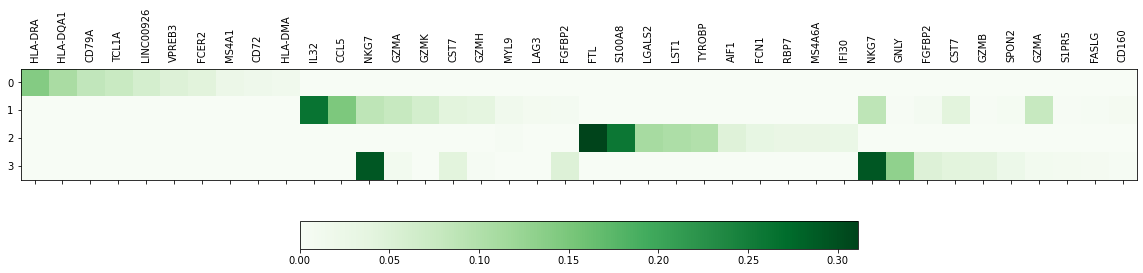

In [8]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
pcm = ax.imshow(encoding_matrix[topix].T,cmap="Greens", vmin=0)
ax.set_yticks(range(P))
ax.set_xticks(range(topD*P))
ax.tick_params(labelbottom=False, labeltop=True)
ax.set_xticklabels(labels=gene_names[topix],rotation=90)
plt.colorbar(pcm, orientation='horizontal', shrink=0.5, ax=ax)
plt.savefig("rnaseq_factorization.pdf",bbox_inches='tight')
plt.show()

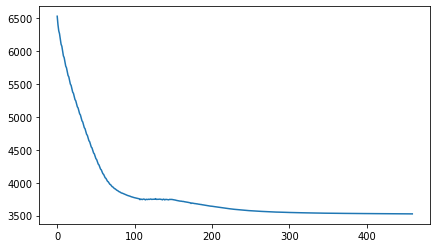

In [9]:
nploss = np.array(losses)
fig = plt.figure(figsize=(7,4))
plt.subplot(111)
plt.plot(nploss)

In [10]:
batch = next(iter(dataset0.batch(1000000)))
X = batch['data']
norms = batch['normalization']
Z = factor.encode(tf.cast(X, tf.float64))

In [11]:
cell_score = (Z*tf.cast(norms[:,tf.newaxis],tf.float64)).numpy()

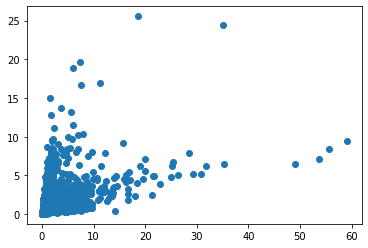

In [12]:
plt.scatter(cell_score[:,0], cell_score[:,1])

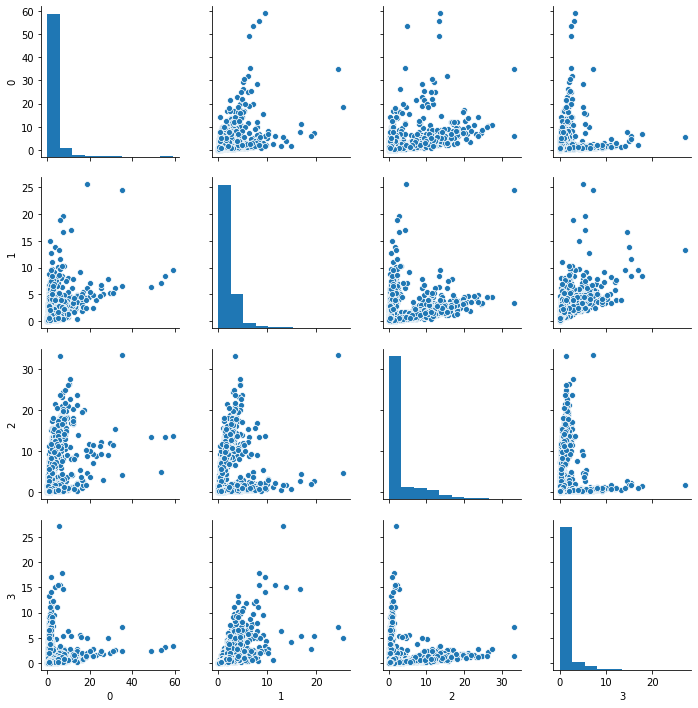

In [13]:
sns.pairplot(pd.DataFrame(cell_score))

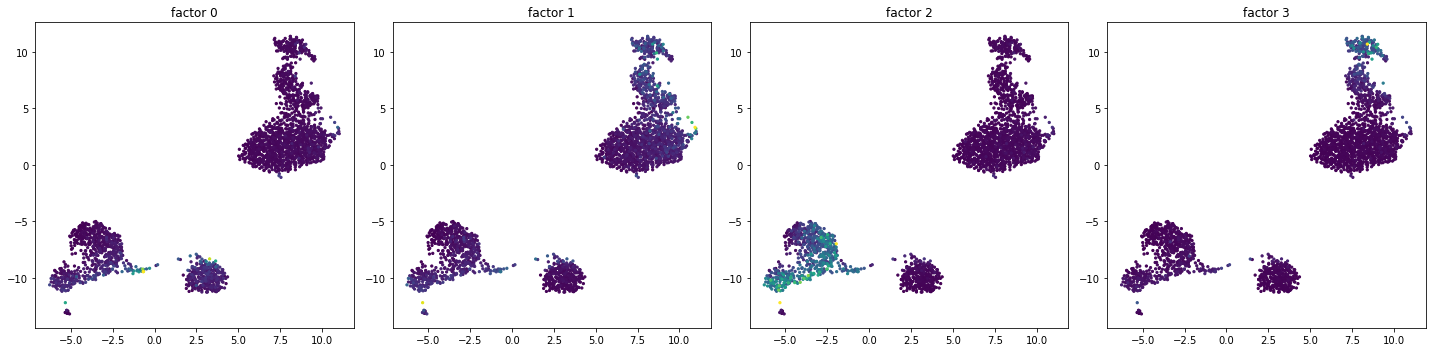

In [15]:
fig, AX = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(AX.flat):
    idx = cell_score[:,i].argsort()
    plt.sca(ax)
    hs = plt.scatter(UMAP[idx,0], UMAP[idx,1], c=cell_score[idx, i], s=5)
    plt.title(f"factor {i}")
plt.tight_layout()
plt.show()